

## Why VolSurface

Vol traders make money in two ways:

1. **Earn premium to cover shortfall**  

   Example: Sell put options (like insurance), earn premiums, and cover in-the-money (ITM) exercises similar to insurance companies.

2. **Charge higher premium than the vol surface implies**  

   Example: *Black–Scholes world*: If flat vol = 20% and you can perfectly delta-hedge, selling at 25% vol gives profit.  
   If you believe true vol = 20% while market shows 25%, sell at 25% and buy back when it reverts to 20%, earn the price diff.

---


## SABR Model

1. **Why SABR?**  

   SABR provides a continuous family of distributions interpolating between **normal** and **lognormal**.

2. **SABR Dynamics**  

\begin{align*}
dF_t = \alpha F_t^{\beta} \ dW_1, \ \ \ \   &F(0) = F_0\\
d\alpha_t = \nu \alpha_t \ dW_2, \ \ \ \      &\alpha(0) = \sigma_0\\
dW_1 \ dW_2 = \rho dt, \ \ \ \              &\rho = \mathrm{corr}(dW_1, dW_2), \\

\end{align*}


- $\alpha_t$ (alpha): Current at-the-money (ATM) volatility  
- $\beta$ (beta): Controls how “lognormal” the model is  
  - $\beta$ = 0 (normal-like): produces a stronger downside skew (higher vol for low strikes).
  - $\beta$ = 1 (lognormal-like): closer to Black–Scholes lognormal dynamics, giving a more symmetric or milder skew.
- $\rho$ (rho): Correlation between spot and volatility; larger ρ → fatter tails
- $\nu$ (VolVol): Controls the slope/height of the volatility smile  
  - Larger ν → stronger smile

2. **Parametetric Intuition**  

- $\alpha_t$: Current at-the-money (ATM) volatility 
- Skew: one-side fatter tail in normal space
  - $\beta$: intuitively, normal distribution has fatter downside tail than lognormal distribution, so that vol surface has more downside skewness when beta is small.
  - $\rho$: intuitively, larger rho means fatter tail
- Smile: two-side fatter tail
  - $\nu$ controls the slope of smile

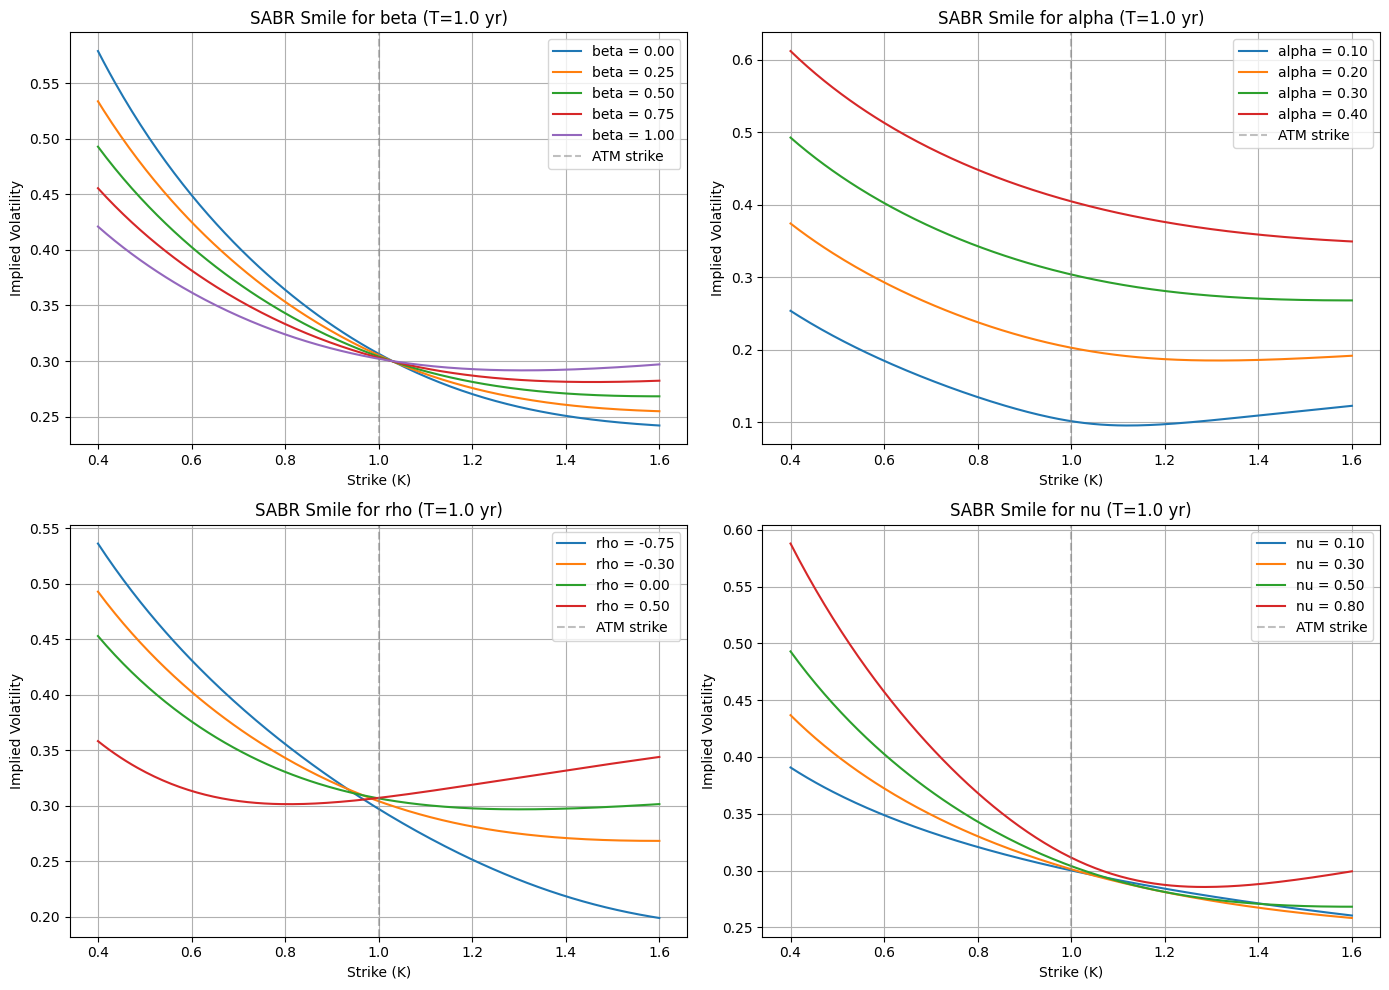

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# SABR implied volatility (Hagan formula)
# -----------------------
def sabr_implied_vol(F, K, T, alpha, beta, rho, nu):
    K = np.array(K, dtype=float)
    eps = 1e-12
    Ksafe = np.where(np.abs(K - F) < eps, F + eps, K)
    fk = F * Ksafe
    one_minus_beta = 1.0 - beta
    lnFK = np.log(F / Ksafe)
    z = (nu / alpha) * (fk ** (one_minus_beta / 2.0)) * lnFK

    # x(z)
    def x_of_z(z):
        small = np.abs(z) < 1e-06
        x = np.empty_like(z)
        idx = ~small
        if np.any(idx):
            zz = z[idx]
            numer = np.sqrt(1 - 2 * rho * zz + zz**2) + zz - rho
            denom = 1 - rho
            x[idx] = np.log(numer / denom)
        if np.any(small):
            z0 = z[small]
            x[small] = z0 - 0.5 * rho * z0**2 + (1.0/6.0)*(2.0*rho**2 + 1.0)*z0**3
        return x

    xz = x_of_z(z)

    correction = 1 + (one_minus_beta**2 / 24.0) * lnFK**2 + (one_minus_beta**4 / 1920.0) * lnFK**4
    A = alpha / (fk ** ((1.0 - beta) / 2.0) * correction)
    B = np.where(np.abs(z) < 1e-08, 1.0, z / xz)
    term1 = (one_minus_beta**2 * alpha**2) / (24.0 * fk**(1.0 - beta))
    term2 = (rho * beta * nu * alpha) / (4.0 * fk**((1.0 - beta) / 2.0))
    term3 = (2.0 - 3.0 * rho**2) * (nu**2) / 24.0
    C = 1.0 + (term1 + term2 + term3) * T
    sigma = A * B * C

    # ATM limit (K ~ F)
    atm_idx = np.abs(K - F) < 1e-08
    if np.any(atm_idx):
        Fbeta = F**(1.0 - beta)
        sigma_atm = (alpha / Fbeta) * (
            1.0
            + ((one_minus_beta**2 * alpha**2) / (24.0 * (F**(2.0 - 2.0*beta)))) * T
            + ((rho * beta * nu * alpha) / (4.0 * (F**(1.0 - beta)))) * T
            + ((2.0 - 3.0 * rho**2) * nu**2 / 24.0) * T
        )
        sigma[atm_idx] = sigma_atm

    return sigma

# -----------------------
# Parameters and grid
# -----------------------
F = 1.0
K_vals = np.linspace(0.4, 1.6, 200)   # strike range
T = 1.0                                # 1 year maturity

# Default SABR params
beta = 0.5
alpha = 0.30
rho   = -0.30
nu    = 0.5

# Alpha, Beta, Rho, Nu values to compare
beta_list = [0.0, 0.25, 0.5, 0.75, 1.0]
alpha_list = [0.1, 0.2, 0.3, 0.4]
rho_list = [-0.75, -0.3, 0.0, 0.5]
nu_list = [0.1, 0.3, 0.5, 0.8]

# -----------------------
# Plot Beta variations
# -----------------------
def plot_all_sabr_smiles(F, K_vals, T, alpha, beta, rho, nu,
                         beta_list, alpha_list, rho_list, nu_list):
    param_lists = [beta_list, alpha_list, rho_list, nu_list]
    param_names = ['beta', 'alpha', 'rho', 'nu']
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    for i, (param_list, param_name) in enumerate(zip(param_lists, param_names)):
        ax = axes[i]
        for val in param_list:
            kwargs = {'alpha': alpha, 'beta': beta, 'rho': rho, 'nu': nu}
            kwargs[param_name] = val
            vols = sabr_implied_vol(F, K_vals, T, kwargs['alpha'], kwargs['beta'], kwargs['rho'], kwargs['nu'])
            label = f"{param_name} = {val:.2f}" if isinstance(val, float) else f"{param_name} = {val}"
            ax.plot(K_vals, vols, label=label)
        ax.axvline(F, color='gray', linestyle='--', alpha=0.5, label="ATM strike")
        ax.set_xlabel("Strike (K)")
        ax.set_ylabel("Implied Volatility")
        ax.set_title(f"SABR Smile for {param_name} (T={T} yr)")
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.show()

# Call the new function:
plot_all_sabr_smiles(F, K_vals, T, alpha, beta, rho, nu,
                     beta_list, alpha_list, rho_list, nu_list)

In [4]:
# SABR Vol Surface with Interactive Widgets
import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D

def compute_surface(alpha, beta, rho, nu):
    vols = np.zeros_like(K_grid)
    for i in range(T_grid.shape[0]):
        vols[i, :] = sabr_implied_vol(F, K_grid[i, :], T_grid[i, 0], alpha, beta, rho, nu)
    return vols

def plot_surface(alpha, beta, rho, nu):
    vols = compute_surface(alpha, beta, rho, nu)
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(K_grid, T_grid, vols, rstride=1, cstride=1)
    ax.set_xlabel('Strike K')
    ax.set_ylabel('Maturity T (yrs)')
    ax.set_zlabel('Implied Vol')
    ax.set_title(f'SABR Implied Vol Surface\nalpha={alpha:.2f}, beta={beta:.2f}, rho={rho:.2f}, nu={nu:.2f}')
    plt.show()

# Grid and default params
F = 1.0                      # normalized forward
K_vals = np.linspace(0.4, 1.6, 80)
T_vals = np.array([0.1, 0.5, 1.0, 2.0])  # we use a small set of maturities for a mesh
K_grid, T_grid = np.meshgrid(K_vals, T_vals)

alpha0 = 0.30
rho0   = -0.30
nu0    = 0.5
beta_default = 0.5

# Interactive widgets for all parameters
alpha_slider = widgets.FloatSlider(value=alpha0, min=0.05, max=1.0, step=0.01, description='alpha:')
beta_slider  = widgets.FloatSlider(value=beta_default, min=0.0, max=1.0, step=0.05, description='beta:')
rho_slider   = widgets.FloatSlider(value=rho0, min=-0.99, max=0.99, step=0.01, description='rho:')
nu_slider    = widgets.FloatSlider(value=nu0, min=0.01, max=2.0, step=0.01, description='nu:')

ui = widgets.VBox([alpha_slider, beta_slider, rho_slider, nu_slider])
out = widgets.interactive_output(
    plot_surface,
    {'alpha': alpha_slider, 'beta': beta_slider, 'rho': rho_slider, 'nu': nu_slider}
)

display(ui, out)

Output()